# System configuration

In [1]:
!git clone https://github.com/inkyubeytor/explainability-challenges.git

fatal: destination path 'explainability-challenges' already exists and is not an empty directory.


In [2]:
!pip3 install torch torchvision torchaudio torchattacks datasets matplotlib opencv-python grad-cam

In [3]:
!pip uninstall explainability-challenges -y

# Preamble

In [4]:
import sys
import torch
import numpy as np
import torchvision
sys.path.insert(1, "./explainability-challenges/src/")

import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms

from explainability.image.image_explanations import grad_cam, eigen_cam, guided_backprop

/opt/homebrew/Caskroom/miniconda/base/envs/10713_test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
transform1 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

def huggingface_to_tensor(image_list):
    image_array_list = [transform1(image.convert('RGB')) for image in image_list]
    #image_array = np.stack(image_array_list, dim=0)

    return torch.stack(image_array_list)

In [6]:
dataset = load_dataset("frgfm/imagenette", "full_size", split="validation")
ood_dataset = huggingface_to_tensor(load_dataset("frgfm/imagewoof", "full_size", split="validation")['image'])

Found cached dataset imagenette (/Users/jrast/.cache/huggingface/datasets/frgfm___imagenette/full_size/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f)
Found cached dataset imagewoof (/Users/jrast/.cache/huggingface/datasets/frgfm___imagewoof/full_size/1.0.0/27966bf439ec61d39fbb620b6c493290e3f75307ab7a7b4d979c61cfe5237a48)


In [7]:
import json
class_idx = json.load(open("/Users/jrast/Downloads/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

# Exploring image explainability methods

## Section 1: GradCAM

In [8]:
def show_image(img):
    img = img.squeeze().permute(1,2,0)
    plt.imshow(img)

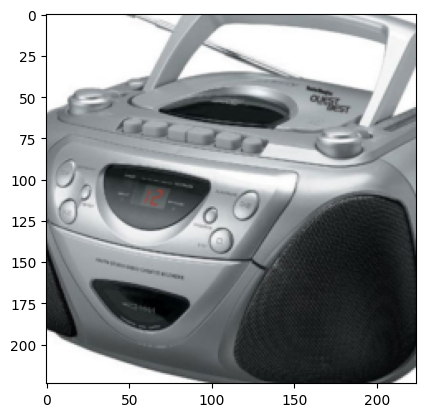

In [9]:
img = dataset[4]['image']
img = (transform1(img) * 255).int().float()

show_image(img / 255)

In [10]:
from torchvision.io import read_image
from torchvision.models import resnet50

In [11]:
from pytorch_grad_cam import EigenCAM, GradCAM
from pytorch_grad_cam.utils.image import scale_cam_image, show_cam_on_image

In [12]:
def grad_cam(image, model):
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers,
                  use_cuda=False)
    targets = None
    grayscale_cam = cam(input_tensor=image, targets=targets)

    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(
        np.moveaxis(image.numpy()[0], 0, -1), grayscale_cam, use_rgb=True)

    return visualization

In [13]:
# transform(img.unsqueeze(dim=0) / 255)

In [14]:
# image = read_image("/Users/jrast/Downloads/test_img.jpg").float().unsqueeze(dim=0)
model = resnet50(pretrained=True).to('cpu')

visualization = grad_cam((img.unsqueeze(dim=0) / 255), model)

In [15]:
transform = torchvision.transforms.Compose([
     torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225]),
 ])

Class: cassette_player


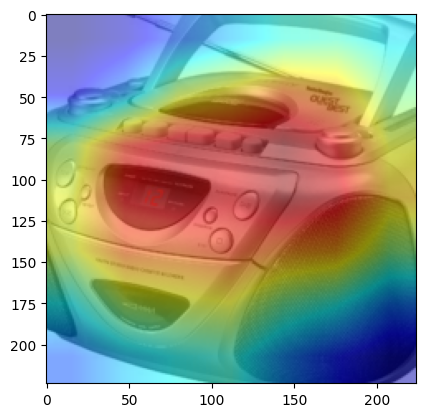

In [16]:
idx = model(transform(img.unsqueeze(dim=0) / 255)).argmax()
label = idx2label[idx]
print(f'Class: {label}')
plt.imshow(visualization)

## Section 2: Guided Backprop

In [17]:
from torchvision import models

In [18]:
img = dataset[4]['image']
img = (transform1(img) * 255).int().float()

In [19]:
model = models.alexnet(pretrained=True)
pos, neg = guided_backprop(transform(img.unsqueeze(dim=0) / 255), model)

In [20]:
idx = model(transform(img.unsqueeze(dim=0) / 255)).argmax()
label = idx2label[idx]
print(label)

cassette_player


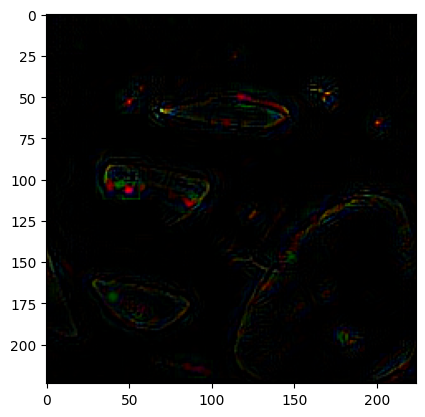

In [21]:
plt.imshow(np.moveaxis(pos.squeeze(), 0, 2))

In [22]:
# TODO: Overlay this with the input image

## Section 3: EigenCAM

In [23]:
image = read_image("/Users/jrast/Downloads/test_img.jpg").float().unsqueeze(dim=0)

In [24]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to("cpu")
model.eval().to("cpu")

visualization = eigen_cam(image, image, model)

In [25]:
ood_dataset[0]

tensor([[[0.7765, 0.7765, 0.7843,  ..., 0.7490, 0.7529, 0.7608],
         [0.7765, 0.7765, 0.7843,  ..., 0.7451, 0.7451, 0.7451],
         [0.7804, 0.7725, 0.7804,  ..., 0.7451, 0.7412, 0.7333],
         ...,
         [0.5176, 0.5176, 0.5216,  ..., 0.4157, 0.4471, 0.4667],
         [0.5137, 0.5137, 0.5216,  ..., 0.4745, 0.4706, 0.4784],
         [0.5137, 0.5137, 0.5216,  ..., 0.4980, 0.4980, 0.4941]],

        [[0.6118, 0.6118, 0.6196,  ..., 0.5765, 0.5804, 0.5843],
         [0.6157, 0.6118, 0.6196,  ..., 0.5804, 0.5804, 0.5804],
         [0.6235, 0.6157, 0.6235,  ..., 0.5882, 0.5804, 0.5725],
         ...,
         [0.4157, 0.4118, 0.4078,  ..., 0.3490, 0.3804, 0.3922],
         [0.4157, 0.4078, 0.4078,  ..., 0.3922, 0.3843, 0.3843],
         [0.4118, 0.4078, 0.4078,  ..., 0.3922, 0.3882, 0.3765]],

        [[0.6157, 0.6157, 0.6235,  ..., 0.5412, 0.5451, 0.5608],
         [0.6196, 0.6157, 0.6235,  ..., 0.5451, 0.5490, 0.5490],
         [0.6235, 0.6157, 0.6235,  ..., 0.5569, 0.5529, 0.

In [26]:
model(image)

[{'boxes': tensor([[   0.,    0., 1100.,  825.],
          [   0.,    0., 1100.,  825.],
          [   0.,    0., 1100.,  825.]], grad_fn=<StackBackward0>),
  'labels': tensor([ 1, 67,  3]),
  'scores': tensor([1.0000, 0.9919, 0.5182], grad_fn=<IndexBackward0>)}]

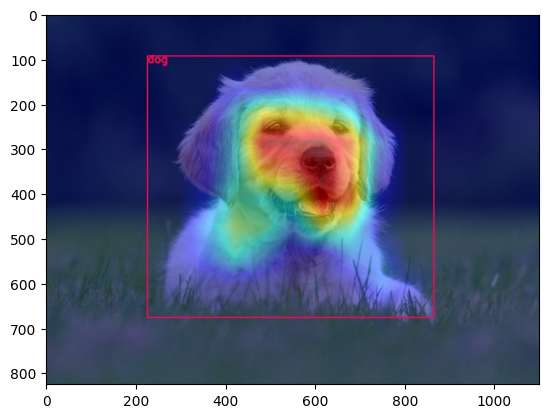

In [27]:
plt.imshow(visualization)

In [28]:
img = dataset[4]['image']
img = (transform1(img) * 255).int().float()

In [29]:
visualization = eigen_cam(ood_dataset[3] * 255, ood_dataset[3] * 255, model)

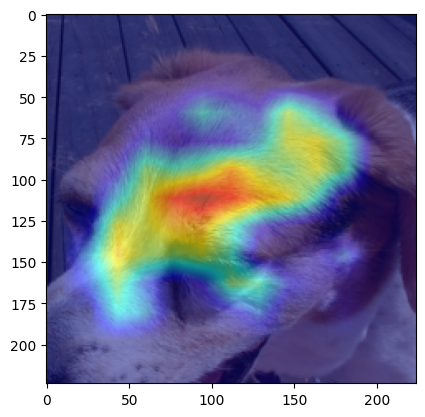

In [30]:
plt.imshow(visualization)

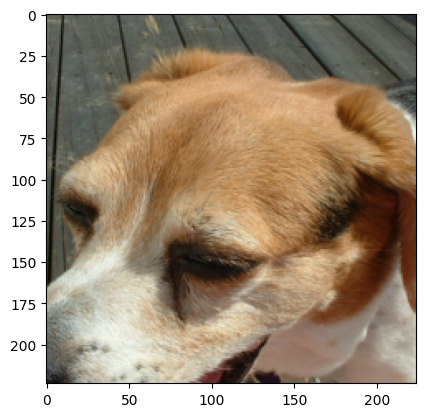

In [31]:
show_image(ood_dataset[3])

In [32]:
data_coco = huggingface_to_tensor(load_dataset("nielsr/coco-panoptic-val2017", split="train")['image'])

Found cached dataset parquet (/Users/jrast/.cache/huggingface/datasets/nielsr___parquet/nielsr--coco-panoptic-val2017-df2fc233520074e5/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


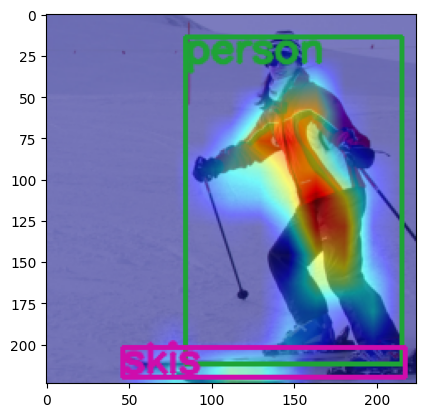

In [33]:
visualization = eigen_cam(data_coco[5] * 255, data_coco[5] * 255, model)
plt.imshow(visualization)